<a href="https://colab.research.google.com/github/quimHM/QHM_TFG_repository/blob/main/MAB_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

#https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits

In [24]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [25]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

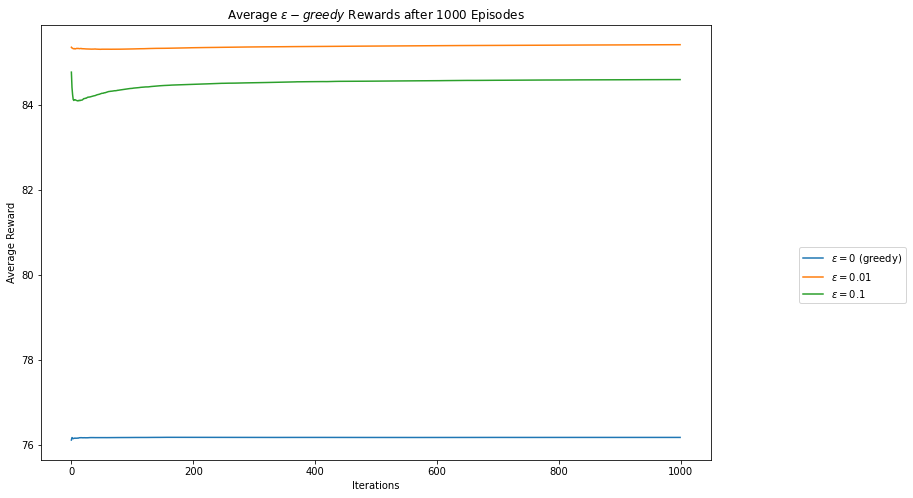

In [26]:
k = 8
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

hmda_mu = [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, hmda_mu)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

In [27]:
print(eps_01.k_n)

[995.   0.   2.   0.   1.   1.   0.   1.]


## **RELLEVANT A PARTIR D'AQUÍ**

In [56]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q, cl):                
        self.q = q        # the true reward value 
        self.confidence_level = cl             
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [57]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))


In [58]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level ):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        return self.total_steps, self.total_reward
  

In [68]:
test = SocketTester(PowerSocket, [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31], 5)
test.run(1000)
test.get_number_of_trials()[-1]

array([963.,  10.,  16.,   6.,   1.,   1.,   2.,   1.])

In [260]:
class SocketTesterBatch():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    
    def run( self, decisions_to_consider, max_percent_decisions=1,maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))
        print("Reward distribution:",[s.q for s in self.sockets])
        
        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 

        print("Intances of each cluster:",self.possibles)
        print("Presence of each in batch:",[i/len(decisions_to_consider) for i in self.possibles])
        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              # test if the accumulated total reward is greater than the maximum
              if self.total_reward > maximum_total_reward:
                  break
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        print("Times selected:",self.get_number_of_trials()[t])
        print("For a total reward:",self.total_reward)

        return self.total_steps, self.total_reward
  

In [261]:
import math
import random

In [262]:
test2 = SocketTesterBatch(PowerSocket, [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31], 5)

decisions = random.choices(range(8), k=1000)
ts,tr = test2.run(decisions)

Reward distribution: [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]
Intances of each cluster: [131, 96, 117, 134, 132, 141, 121, 128]
Presence of each in batch: [0.131, 0.096, 0.117, 0.134, 0.132, 0.141, 0.121, 0.128]
Times selected: [131.  96. 117. 134. 132. 140. 121. 128.]
For a total reward: 75836.90164875134


In [263]:
ts,tr = test2.run(decisions, 0.8)

Reward distribution: [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]
Intances of each cluster: [131, 96, 117, 134, 132, 141, 121, 128]
Presence of each in batch: [0.131, 0.096, 0.117, 0.134, 0.132, 0.141, 0.121, 0.128]
Times selected: [131.  96. 117. 134. 132.  22. 121.  47.]
For a total reward: 62584.135071480654


In [264]:
sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
sample_bias_decisions = random.choices(range(8),weights=sample_bias,k=1000)
#print(sample_bias_decisions)
ts,tr = test2.run(sample_bias_decisions, 0.8)

Reward distribution: [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]
Intances of each cluster: [586, 233, 17, 8, 75, 79, 2, 0]
Presence of each in batch: [0.586, 0.233, 0.017, 0.008, 0.075, 0.079, 0.002, 0.0]
Times selected: [586. 184.  17.   8.   2.   1.   2.   0.]
For a total reward: 67688.99010448945
